# Loading The Data

In [ ]:
# Load the data
import gdown
import zipfile

url = 'https://drive.google.com/uc?id=1boGQI1TIDhnQbq9QQjBM0NHrYewOtpnn'
output = 'dog-images.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('dog-images')

Downloading...
From: https://drive.google.com/uc?id=1boGQI1TIDhnQbq9QQjBM0NHrYewOtpnn
To: /content/dog-images.zip
100%|██████████| 724M/724M [00:07<00:00, 103MB/s]


In [ ]:
#validate data was retrieved, check amount of images in train and test
import os

train_path = 'dog-images/train'
test_path = 'dog-images/test'

train_images_count = len(os.listdir(train_path))
test_images_count = len(os.listdir(test_path))

Number of images in the train folder: 10222
Number of images in the test folder: 10357


In [ ]:
#load the labels
import pandas as pd

dog_breeds_labels = pd.read_csv('dog-images/labels.csv')

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

# Get all your imports

In [ ]:
import tensorflow as tf
import keras
from keras import layers

In [ ]:
import pandas as pd
import numpy as np

from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from matplotlib.pyplot import imread
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers, models
from tensorflow import keras
from keras.models import Sequential, load_model
import tensorflow_hub as hub
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from PIL import Image


import os


import cv2
import seaborn as sns



In [ ]:
distinct_labels = dog_breeds_labels['breed'].unique()
distinct_len = len(distinct_labels)

In [ ]:
# Setup input shape to the model
IN_SHAPE = [None, 224, 224, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUT_SHAPE = distinct_len

# URL for MobileNet v2
MOBILENET_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"

from itertools import product

learning_rate = [0.01, 0.001]
filters = [32, 64]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dog_breeds_labels['id'] = dog_breeds_labels['id'].str.replace('.jpg', '', regex=False)
dog_breeds_labels['id'] = dog_breeds_labels['id'] + '.jpg'
# data augmentation technique
datagen = ImageDataGenerator(
    rescale=1./255,    # Rescale pixel values
    validation_split=0.2,  # Split data into 80% train and 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    dataframe=dog_breeds_labels,
    directory='dog-images/train',
    x_col='id',
    y_col='breed',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=dog_breeds_labels,
    directory='dog-images/train',
    x_col='id',
    y_col='breed',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [ ]:
#History Plotting Helper Function
import matplotlib.pyplot as plt
def plot_graph(history):
    # training - validation accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # training  - validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
# Load MobileNetV2 without top classification layer
learning_rate = [0.01, 0.001]
filters = [32, 64]
params = list(product(learning_rate, filters))
iter = 1

for param in params:
  alpha = param[0]
  filter = param[1]

  mobilenet_v2_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
  mobilenet_v2_feature_extractor = hub.KerasLayer(mobilenet_v2_url, input_shape=(224, 224, 3), trainable=False)

  # Create the model
  model = tf.keras.Sequential([
      mobilenet_v2_feature_extractor,  # MobileNetV2 feature extractor
      tf.keras.layers.Flatten()
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(units=120, activation='softmax')  # Replace num_classes with the number of classes
  ])
  model.add(tf.keras.layers.Dense(filter, activation='relu'))

  model.add(tf.keras.layers.Dense(120, activation='softmax'))
  # Compile the model with an appropriate loss and optimizer
  model.compile(#optimizer='adam',
                optimizer=tf.keras.optimizers.Adam(learning_rate = alpha),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  print(f'\nIteration #: {iter} \tNumber of Filters: {filter} \tLearning Rate: {alpha}')
  model.summary()

  history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=2
  )

  plot_graph(history)
  iter += 1


Iteration #: 1 	Number of Filters: 32 	Learning Rate: 0.01
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 flatten_2 (Flatten)         (None, 1001)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                32064     
                                                                 
 dense_5 (Dense)             (None, 120)               3960      
                                                                 
Total params: 5468737 (20.86 MB)
Trainable params: 36024 (140.72 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________
Epoch 1/2
107/256 [===========>..................] - ETA: 5:17 - loss: 3.1453 - ac

KeyboardInterrupt: ignored

In [ ]:
mobilenet_v2_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
mobilenet_v2_feature_extractor = hub.KerasLayer(mobilenet_v2_url, input_shape=(224, 224, 3), trainable=False)

best_model = tf.keras.Sequential([
    mobilenet_v2_feature_extractor,
    tf.keras.layers.Flatten()
])
best_model.add(tf.keras.layers.Dense(32, activation='relu'))

best_model.add(tf.keras.layers.Dense(120, activation='softmax'))
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
best_model.summary()
history = best_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=2
  )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 flatten_1 (Flatten)         (None, 1001)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                32064     
                                                                 
 dense_3 (Dense)             (None, 120)               3960      
                                                                 
Total params: 5468737 (20.86 MB)
Trainable params: 36024 (140.72 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________
Epoch 1/2
256/256 [==============================] - 698s 3s/step - loss: 2.9548 - accuracy: 0.3315 - val_loss: 1.5661 - val_accuracy: 0.5675


1/1 [==============================] - 1s 962ms/step


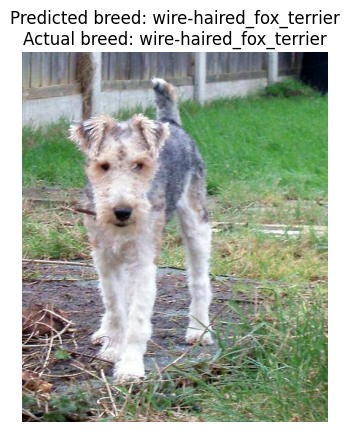

1/1 [==============================] - 0s 162ms/step


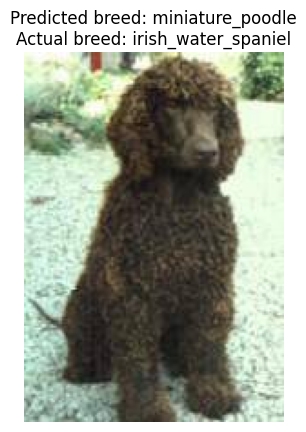

1/1 [==============================] - 0s 150ms/step


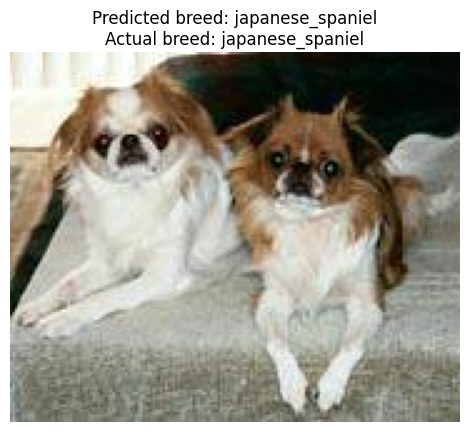

1/1 [==============================] - 0s 132ms/step


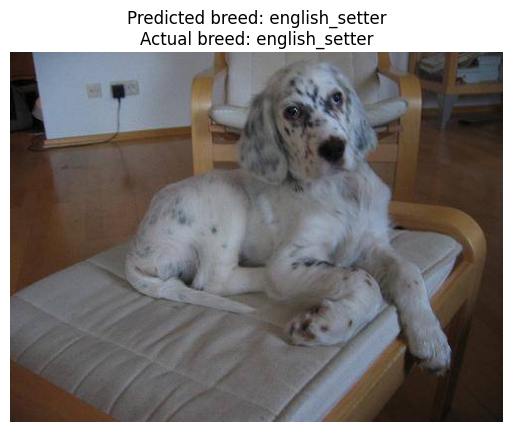

1/1 [==============================] - 0s 113ms/step


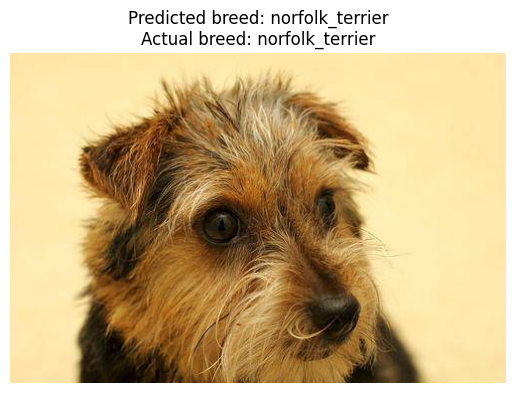

1/1 [==============================] - 0s 76ms/step


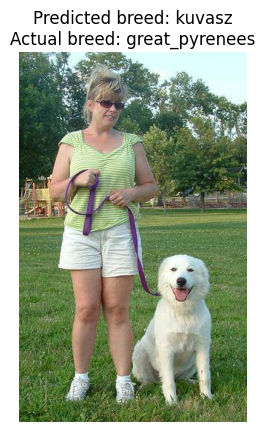

1/1 [==============================] - 0s 73ms/step


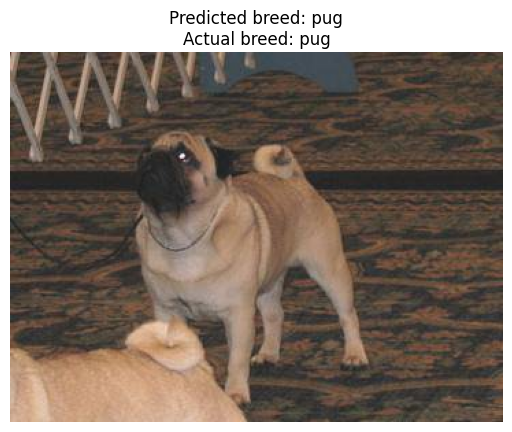

1/1 [==============================] - 0s 73ms/step


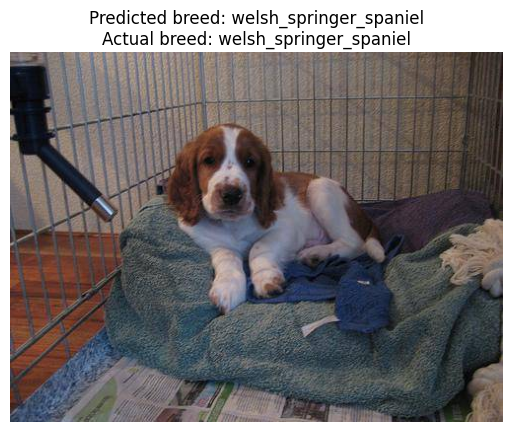

1/1 [==============================] - 0s 110ms/step


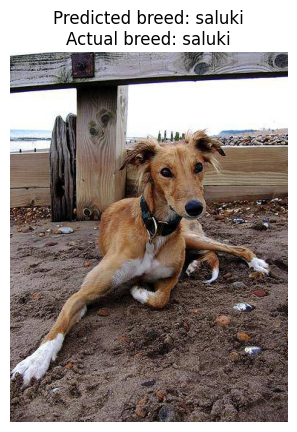

1/1 [==============================] - 0s 109ms/step


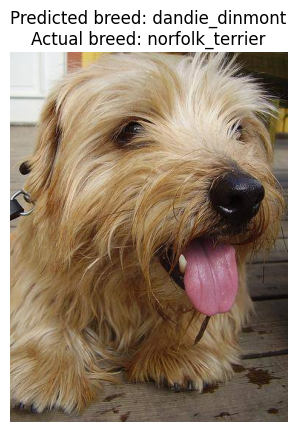

1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 98ms/step


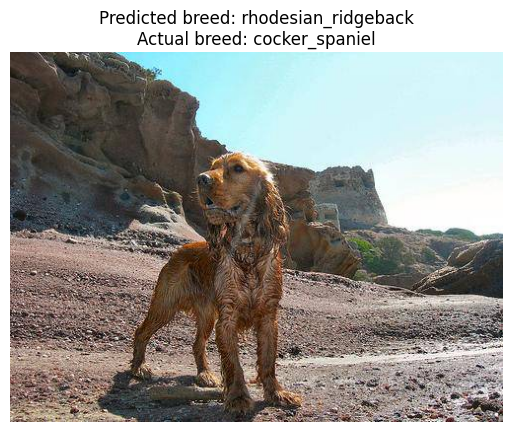

1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 128ms/step


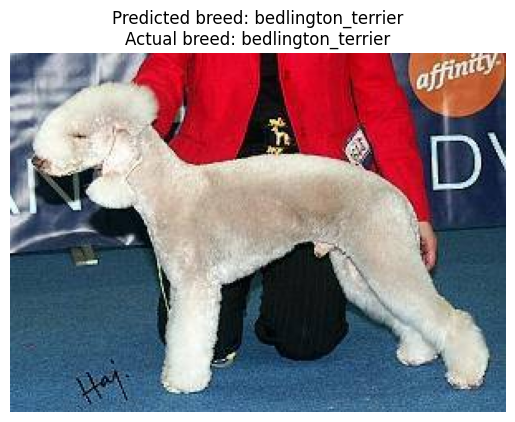

1/1 [==============================] - 0s 110ms/step


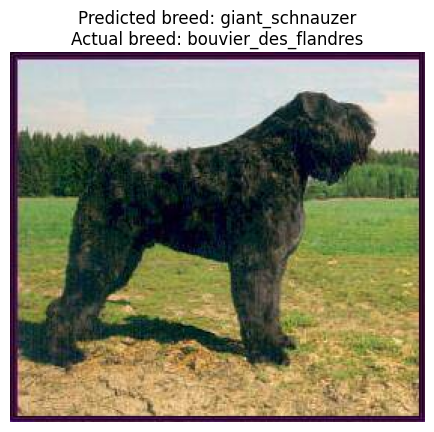

1/1 [==============================] - 0s 103ms/step


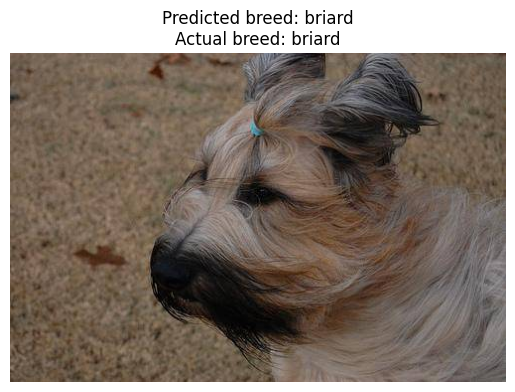

1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 110ms/step


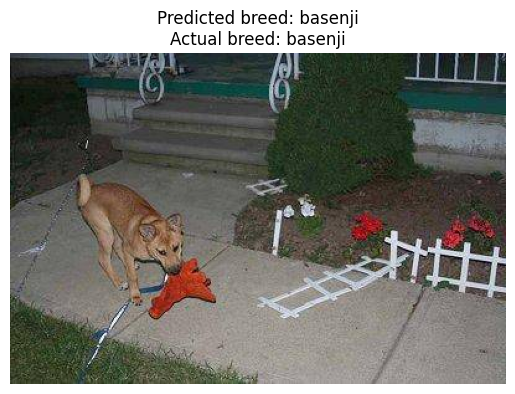

1/1 [==============================] - 0s 126ms/step


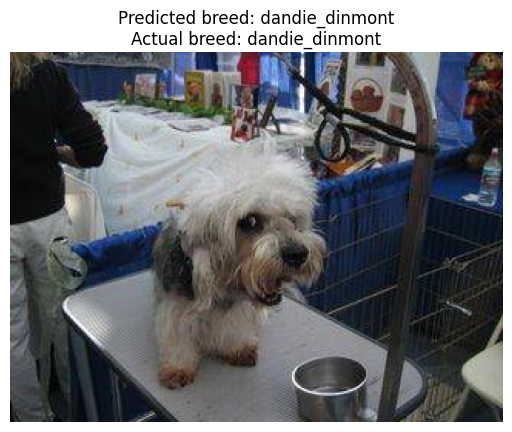

1/1 [==============================] - 0s 115ms/step


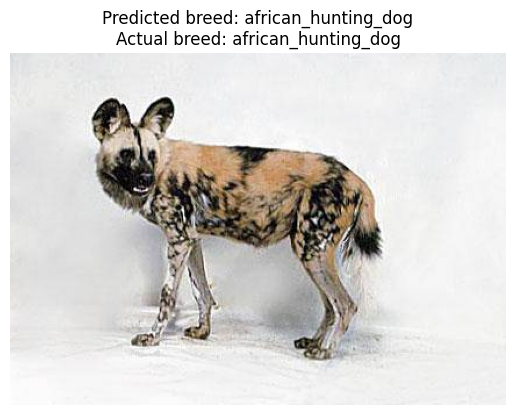

1/1 [==============================] - 0s 114ms/step


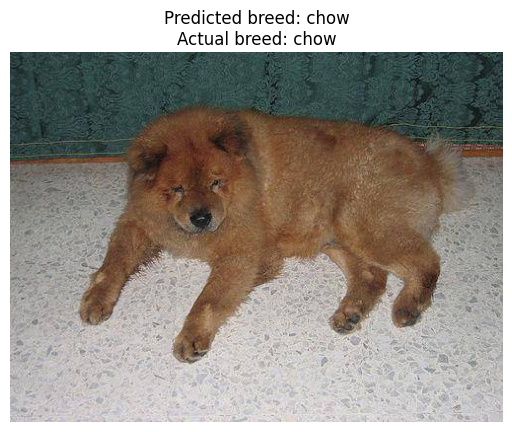

1/1 [==============================] - 0s 121ms/step


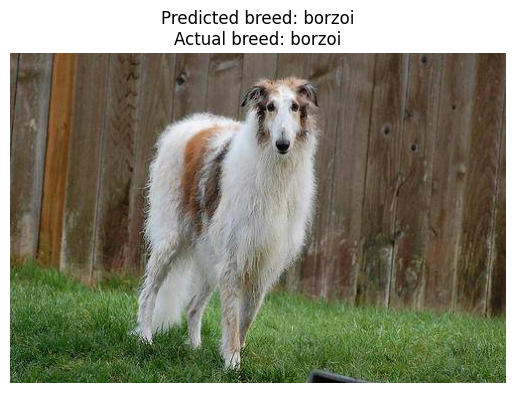

1/1 [==============================] - 0s 118ms/step


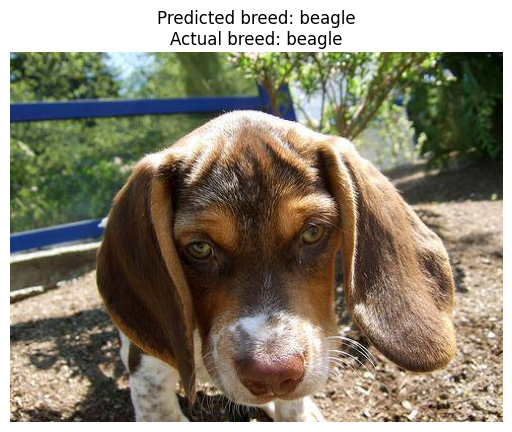

1/1 [==============================] - 0s 179ms/step


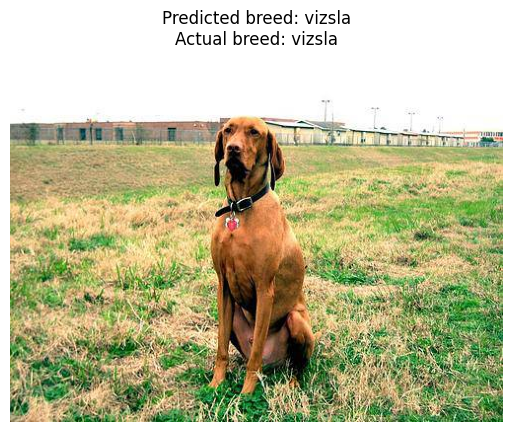

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf


# Load and preprocess a sample test image
def load_img(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = image_array / 255.0  # Normalize pixel values
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

# Function to get the actual breed from labels.csv
def true_value(image_file):
    image_id = image_file.split('.')[0]  # Remove the file extension
    actual_breed = dog_breeds_labels.loc[dog_breeds_labels['id'] == (image_id+'.jpg')].values[0]
    return actual_breed

# Predict the breed for a few sample test images
sample_test_images = os.listdir('dog-images/train')[:25]
for image_file in sample_test_images:
    image_path = os.path.join('dog-images/train', image_file)
    image_array = load_img(image_path)
    predictions = best_model.predict(image_array)
    predicted_breed = np.argmax(predictions)
    predicted_breed_name = list(train_generator.class_indices.keys())[predicted_breed]

    # Get the actual breed from labels.csv
    actual_breed_name = true_value(image_file)

    # Display the image with predicted and actual breed
    plt.imshow(tf.keras.preprocessing.image.load_img(image_path))
    plt.title(f"Predicted breed: {predicted_breed_name}\nActual breed: {actual_breed_name[1]}")
    plt.axis('off')
    plt.show()
